# 🧪 Interpreting Bias in Word Embeddings with WEAT
This notebook demonstrates how to use the Word Embedding Association Test (WEAT) to detect and interpret bias in pretrained word embeddings (Word2Vec).

In [1]:

import numpy as np
from gensim.downloader import load

# Load word vectors
vectors = load('word2vec-google-news-300')


In [2]:
# 📦 Install and import dependencies
from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

In [ ]:
# # 🔄 Load pretrained Google News Word2Vec embeddings
# # You must download the model from: https://code.google.com/archive/p/word2vec/
# model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

In [3]:
# 🔤 Define word sets
target1 = ["engineer", "scientist", "programmer", "mathematician"]
target2 = ["nurse", "teacher", "librarian", "receptionist"]
attribute1 = ["he", "him", "his", "man", "male"]
attribute2 = ["she", "her", "hers", "woman", "female"]

def filter_vocab(words):
    return [w for w in words if w in vectors]

target1 = filter_vocab(target1)
target2 = filter_vocab(target2)
attribute1 = filter_vocab(attribute1)
attribute2 = filter_vocab(attribute2)

In [4]:
# 📏 Compute WEAT effect size
def association(w, A, B):
    return np.mean([vectors.similarity(w, a) for a in A]) - np.mean([vectors.similarity(w, b) for b in B])

def weat_effect_size(X, Y, A, B):
    s_X = [association(x, A, B) for x in X]
    s_Y = [association(y, A, B) for y in Y]
    return (np.mean(s_X) - np.mean(s_Y)) / np.std(s_X + s_Y)

effect_size = weat_effect_size(target1, target2, attribute1, attribute2)
print(f"WEAT Effect Size: {effect_size:.3f}")

WEAT Effect Size: 1.835


In [5]:
# 🔁 Permutation test for significance
def permutation_test(X, Y, A, B, num_samples=10000):
    XY = X + Y
    observed = weat_effect_size(X, Y, A, B)
    more_extreme = 0

    for _ in range(num_samples):
        np.random.shuffle(XY)
        X_i = XY[:len(X)]
        Y_i = XY[len(X):]
        stat = weat_effect_size(X_i, Y_i, A, B)
        if abs(stat) >= abs(observed):
            more_extreme += 1

    return observed, more_extreme / num_samples

observed, p_value = permutation_test(target1, target2, attribute1, attribute2)
print(f"Observed Effect Size: {observed:.3f}")
print(f"P-value (Permutation Test): {p_value:.4f}")

Observed Effect Size: 1.835
P-value (Permutation Test): 0.0316


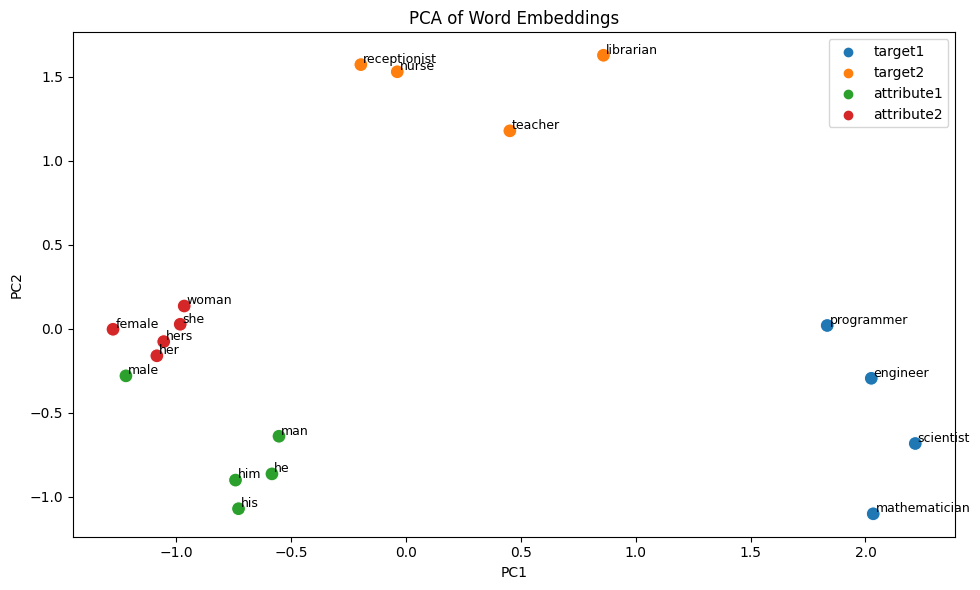

In [7]:
# 📊 Visualize embeddings with PCA
all_words = target1 + target2 + attribute1 + attribute2
vectors = [vectors[w] for w in all_words]
labels = all_words
categories = (["target1"] * len(target1) + ["target2"] * len(target2) +
              ["attribute1"] * len(attribute1) + ["attribute2"] * len(attribute2))

pca = PCA(n_components=2)
points = pca.fit_transform(vectors)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=points[:, 0], y=points[:, 1], hue=categories, s=100)

for i, label in enumerate(labels):
    plt.text(points[i, 0]+0.01, points[i, 1]+0.01, label, fontsize=9)

plt.title("PCA of Word Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:

# Compute gender direction (from 'he' to 'she')
gender_direction = vectors['she'] - vectors['he']

# Function to compute projection onto gender direction
def project_onto_direction(word_vec, direction):
    return np.dot(word_vec, direction) / np.linalg.norm(direction)

# Words to project
words_to_project = ['nurse', 'scientist', 'teacher', 'engineer', 'programmer', 'mathematician', 'librarian']

# Compute projections
projections = {word: project_onto_direction(vectors[word], gender_direction) for word in words_to_project}

# Plot projections
plt.figure(figsize=(10, 5))
plt.bar(projections.keys(), projections.values())
plt.axhline(0, color='black', linestyle='--')
plt.title("Projection of Profession Words onto Gender Direction (he → she)")
plt.ylabel("Projection Value")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


TypeError: list indices must be integers or slices, not str

In [9]:
embeddings = vectors
from scipy.spatial.distance import cosine

# Define attribute sets
A = ['he', 'him', 'his', 'man']
B = ['she', 'her', 'hers', 'woman']

# Define target sets
X = ['engineer', 'scientist', 'programmer', 'mathematician']
Y = ['nurse', 'teacher', 'librarian', 'receptionist']

# Function to compute association of word with attributes
def association(w, A, B):
    return np.mean([1 - cosine(embeddings[w], embeddings[a]) for a in A]) - \
           np.mean([1 - cosine(embeddings[w], embeddings[b]) for b in B])

# Compute WEAT effect size
mean_X = np.mean([association(x, A, B) for x in X])
mean_Y = np.mean([association(y, A, B) for y in Y])
std_dev = np.std([association(w, A, B) for w in X + Y])
weat_effect_size = (mean_X - mean_Y) / std_dev

print(f"WEAT Effect Size (STEM vs Social jobs): {weat_effect_size:.3f}")


TypeError: list indices must be integers or slices, not str

In [ ]:

# Add more professions across gender and racial lines
extended_words = ['nurse', 'teacher', 'librarian', 'receptionist', 'scientist', 'engineer', 'mathematician', 'programmer',
                  'janitor', 'chef', 'pilot', 'surgeon', 'CEO', 'athlete', 'lawyer', 'cashier']

extended_vectors = np.array([embeddings[word] for word in extended_words])
pca = PCA(n_components=2)
ext_pca_result = pca.fit_transform(extended_vectors)

plt.figure(figsize=(12, 6))
for i, word in enumerate(extended_words):
    plt.scatter(ext_pca_result[i, 0], ext_pca_result[i, 1])
    plt.text(ext_pca_result[i, 0] + 0.01, ext_pca_result[i, 1] + 0.01, word)
plt.title("PCA of Extended Profession Words")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [ ]:

# This assumes you have pre-loaded debiased embeddings in `debiased_embeddings`
# We'll replot the same PCA using debiased vectors

deb_vectors = np.array([debiased_embeddings[word] for word in extended_words])
deb_pca_result = pca.fit_transform(deb_vectors)

plt.figure(figsize=(12, 6))
for i, word in enumerate(extended_words):
    plt.scatter(deb_pca_result[i, 0], deb_pca_result[i, 1])
    plt.text(deb_pca_result[i, 0] + 0.01, deb_pca_result[i, 1] + 0.01, word)
plt.title("PCA of Extended Words (Debiased Embeddings)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()
